# The Residual Overturning Circulation (ROC)

Sometimes in stratified fluids it makes a lot of sense to average on isopycnals. The residual overturning circulation is the volume transport averaged on density layers, rather than at constant depth. 

The meridional volume transport in a layer is 
\begin{equation} 
<vh> = <\int v(x,y, z,t) \delta [c(x,y,z,t) - \tilde{c}] dz>,
\end{equation}
    
where <.> corresponds to an average. This averaging can be a time average or zonal average or ensemble average or some combination. 
    
We can also define a thickness weighted velocity $\hat{v} = <vh> / <h>$. 
    
The corresponding streamfunction is defined as 
    \begin{equation} 
    \psi (x,y,\tilde{c},t) = - \int^{\tilde{c}} <vh> dc'
    \end{equation}
More details in appendix of Wolfe 2014.
    


**Numerical implementation**

The implementation is quite straightforward, and we simply need to use the function vertical_sum. This calculates the numerator of equation 1, which the quantity that we will average. 


In [2]:
import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import gcsfs
from xhistogram.xarray import histogram

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

In [3]:
#This code defines a function that lets us read the data later
def read_data(uri):
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

In [4]:
def vertical_sum(data, bin_data, bins, dz, vert_dim="st_ocean"):
    """ This function calculates the vertical sum of a variable but weighted by the dirac-delta
    functions, as shown in the first equation. """
    
    nanmask = np.isnan(data)
    # Should we also check the bin data for nans?
    full_sum = histogram(
        bin_data.where(~nanmask),
        bins=[bins],
        weights=(data * dz).where(~nanmask),
        dim=[vert_dim],
    )
    return full_sum


## Things to add/fix: 
# a) right now the density is also averaged on the density, do we need this?
# b) Estimate the probability of finding a density layer at a location, because some 
# tracer layers might be present at a location only for part of the year.

def vertical_rebin_wrapper(
    ds,
    bin_data_name,
    bins,
    dz_name="dz",
    vert_dim="st_ocean",
    return_average=True,
    debug=False,
):
    """A wrapper for the core functionality in `vertical_rebin`.
    Accepts datasets and calculates the average over the new depth coordinates.
    
    Inputs:
    ds - the Dataset with one of the variables being the tracer that would be the new grid.
    tracer_name - the tracer variable name to which the regridding will be done. 
    bins - the discrete tracer bins into which will form the ranges for the new vertical grid.
    dz_name  - the variable name for the cell sizes on a z grid (or cell sizes for current vertical grid)
    vert_dim - current vertical dimension of the data
    
    Outputs: 
    A new data set where all variables have been regridded to a new vertical grid. Also contains a variable
    called 'thickness', which is the sigma in the equation above. 
    """
    
    
    ds = ds.copy() # the input
    ds_rebinned = xr.Dataset() # the output
    
    ones = xr.ones_like(ds[dz_name]) 
    
    # Estimate the thickness of each tracer bin.
    # this is the calculation of sigma
    thickness = vertical_sum(
        ones,
        ds[bin_data_name],
        bins,
        ds[dz_name],
        vert_dim=vert_dim,
    )
    
    # Estimate the vertical integrals in the numerator
    for var in ds.data_vars:
        ds_rebinned[var] = vertical_sum(
            ds[var], ds[bin_data_name], bins, ds[dz_name], vert_dim=vert_dim
        )
        
    if return_average:
        ds_rebinned = (
            ds_rebinned / thickness
        )  
        # this might cause a lot of overhead...i can try to deactivate if the save fails.
        # this is needed, or else ds_rebinned has the wrong units (multiplied by thickness).

    ds_rebinned['thickness'] = thickness

    return ds_rebinned

In [5]:
#Here is where you pick what variable you want to look at.
table_id='Omon'
variable_id='no3'

#Now pick what model you want to look at
source_id='CNRM-ESM2-1'
experiment_id='historical'

#first we load the catalogue
import pandas as pd
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')

#Then we load the variable you want
df_var = df[(df.table_id == table_id) & (df.variable_id == variable_id)]
uri = df_var[(df_var.source_id == source_id) &
                         (df_var.experiment_id == experiment_id)].zstore.values[0]
ds_var = read_data(uri)

#Now we also need to load temperature and salinity, so that we can find density
df_theta = df[(df.table_id == table_id) & (df.variable_id == 'thetao')]
uri = df_theta[(df_theta.source_id == source_id) &
                         (df_theta.experiment_id == experiment_id)].zstore.values[0]
ds_theta = read_data(uri)

df_salt = df[(df.table_id == table_id) & (df.variable_id == 'so')]
uri = df_salt[(df_salt.source_id == source_id) &
                         (df_salt.experiment_id == experiment_id)].zstore.values[0]
ds_salt = read_data(uri)

In [6]:
# We also need a variable that measures dZ
df_dz = df[(df.table_id == table_id) & (df.variable_id == 'thkcello')]
uri = df_dz[(df_dz.source_id == source_id) &
                         (df_dz.experiment_id == experiment_id)].zstore.values[0]
dz = read_data(uri)

In [7]:
#Here we calculate the approximate potential density 
#(note: Not all CMIP6 models use TEOS-10, so this potential density is only approximate)
# Since we are looking at the full water column might be better to work with sigma2
import gsw
dens=xr.apply_ufunc(gsw.density.sigma0,ds_salt['so'], ds_theta['thetao'],dask='parallelized', output_dtypes=[float, ]
                   ).rename('dens').to_dataset()

In [8]:
#Here we merge the data. You could have problems if you choose a variable that's not on T,S gridpoints
# this problem is faced below when working with velocities (needs a solution.)
ds = xr.merge([dens, ds_var, dz])

In [11]:
#define bins (in units of potential density)
bins = np.arange(20, 30, 0.2) # you could also try non-uniform bin size 
#Define vertical coord
vert_coord='lev'
vert_grid_space = 'thkcello'

In [12]:
# Actually rebin the data
ds_rebinned = vertical_rebin_wrapper(ds,
                                     'dens',
                                     bins,
                                     dz_name=vert_grid_space,
                                     vert_dim=vert_coord) # be careful about dz_name, and vert_dim

In [13]:
# load the zonal and meridional velocity 

## u
table_id='Omon'
variable_id='uo'

#Now pick what model you want to look at
source_id='CNRM-ESM2-1'
experiment_id='historical'

#first we load the catalogue
import pandas as pd
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')

#Then we load the variable you want
df_var = df[(df.table_id == table_id) & (df.variable_id == variable_id)]
uri = df_var[(df_var.source_id == source_id) &
                         (df_var.experiment_id == experiment_id)].zstore.values[0]
ds_u = read_data(uri)

## v
table_id='Omon'
variable_id='vo'

#Now pick what model you want to look at
source_id='CNRM-ESM2-1'
experiment_id='historical'

#first we load the catalogue
import pandas as pd
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')

#Then we load the variable you want
df_var = df[(df.table_id == table_id) & (df.variable_id == variable_id)]
uri = df_var[(df_var.source_id == source_id) &
                         (df_var.experiment_id == experiment_id)].zstore.values[0]
ds_v = read_data(uri)

!! We need to add the transport associated with GM here (it is not part of uo and vo).

!!! Needs fixing below. 

In [14]:
ds_vels = xr.merge([ds_u, ds_v], compat='override') 
# the override puts the u and v on the same grid point. We should fix this by using interpolation from xgcm.
# if you try merging with the option an error will be spit out. 

In [15]:
ds_vels

<xarray.Dataset>
Dimensions:      (axis_nbounds: 2, lev: 75, nvertex: 4, time: 1980, x: 362, y: 294)
Coordinates:
    bounds_lat   (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    bounds_lon   (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    lat          (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    lev_bounds   (lev, axis_nbounds) float64 dask.array<chunksize=(75, 2), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    uo           (time, lev, y, x) float32 dask.array<chunksize=(12, 75, 294, 362), meta=np.ndarray>
    vo

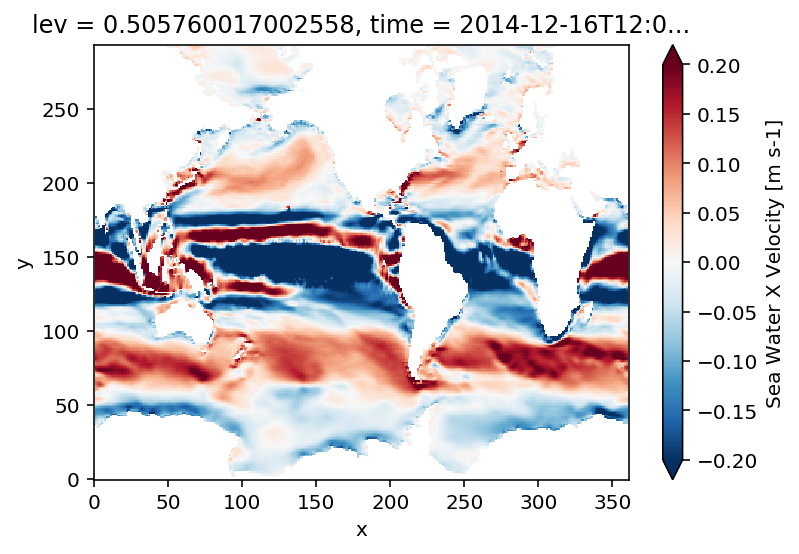

In [16]:
ds_vels['uo'].isel(time=-1).sel(lev=0, method='nearest').plot(vmin=-0.2)
# velocities look good, there is an ACC!! 

In [17]:
# Function to estimate the thickness weighted sum (<uh>) (not average, just sum )
def TWS_wrapper(
    ds_vels,
    bin_data_name,
    bins,
    dz_name="dz",
    vert_dim="st_ocean",
    return_average=True,
    debug=False,
):
    """A wrapper for estimating thickness weighted sum, basically just uses vertical_sum
    
    Inputs:
    ds_vels - the Dataset with u and v velocity
    tracer_name - the tracer variable name to which the regridding will be done. 
    bins - the discrete tracer bins into which will form the ranges for the new vertical grid.
    dz_name  - the variable name for the cell sizes on a z grid (or cell sizes for current vertical grid)
    vert_dim - current vertical dimension of the data
    
    Outputs: 
    A new data set where all variables have been regridded to a new vertical grid. 
    TWS - thickness weighted sum 
    """
    
    ds_vels = ds_vels.copy() # the input
    ds_TWS = xr.Dataset() # the output
        
    # Estimate the velocity times the thickness of the layer
    for var in ds_vels.data_vars:
        ds_TWS[var] = vertical_sum(
            ds_vels[var], ds_vels[bin_data_name], bins, ds_vels[dz_name], vert_dim=vert_dim
        )
        
    return ds_TWS

### To do 
a) write tests
b) since the variable is changing form it makes sense to rename the variable names

In [19]:
# Even though the u, v, density are not on the same grid points let us assume they are. 
# Note: this interpolation bit can be taken care of later (upgrade)
ds_vels = xr.merge([ds_vels, dens, ds.thkcello], compat='override')

In [20]:
ds_TWS = TWS_wrapper(ds_vels, 'dens', bins, dz_name='thkcello', vert_dim='lev')

In [21]:
# calculate an average in time and over zonal direction
# Can be done better by taking care of land masks
# should be a sum in 'x' instead of average
vh_bar = ds_TWS.vo.isel(time=slice(-37,-1)).mean(['time','x'])
vh_bar.load()

<xarray.DataArray 'vo' (y: 294, dens_bin: 49)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 3.37371060e-06, -1.16134589e-05, -2.04044715e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.18945757e-05,  1.23769946e-05,  7.79395469e-06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
  * dens_bin  (dens_bin) float64 20.1 20.3 20.5 20.7 ... 29.1 29.3 29.5 29.7
Dimensions without coordinates: y

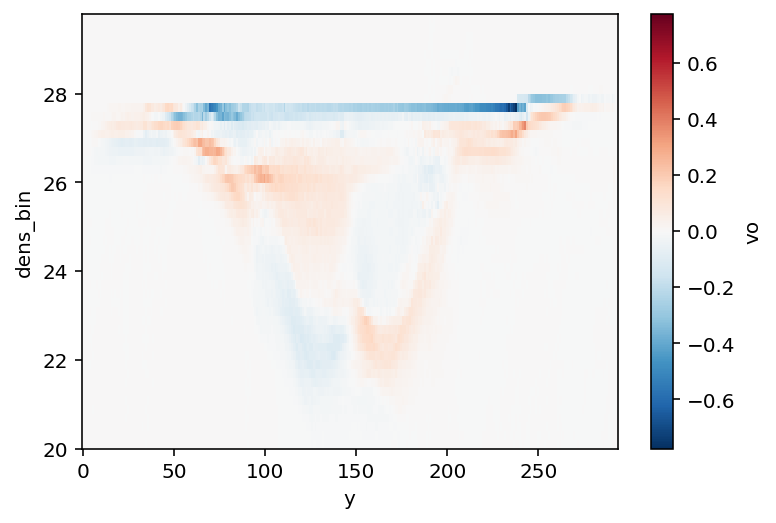

In [22]:
(vh_bar.T).plot()
# one thing to note about this plot is that at some y locations, 
# some of the density layers are not always present. They still have a mean associated with them. 

In [23]:
# Go to stream function from TWS, basically integrate in the vertical over density bins 
psi = vh_bar.cumsum(['dens_bin'])*0.2*3e7 
# hard coded factors for binsize and circumfrence 

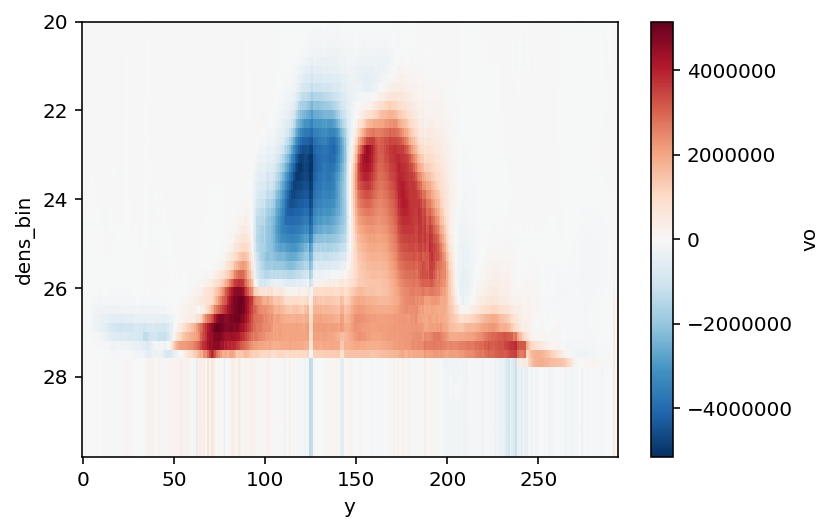

In [24]:
(psi.T).plot()
plt.gca().invert_yaxis()


Rough way to project this back to Z is by using the thickness 

In [26]:
Y = ds_vels.bounds_lat.mean(['x','nvertex']).load() # being sloppy here
Z = ds_rebinned.thickness.cumsum('dens_bin').isel(time=slice(-37,-1)).mean(['time','x']).load()

In [27]:
Ynew = np.expand_dims(Y.values, axis=1)
Ynew = np.repeat(Ynew, 49, axis=1)

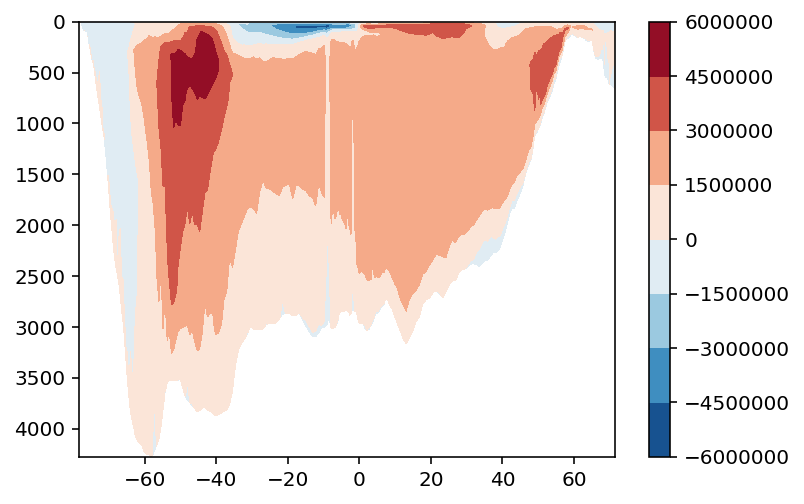

In [28]:
plt.contourf(Ynew,Z, psi, cmap='RdBu_r')
plt.gca().invert_yaxis()
plt.colorbar()

!!! This figure above is not perfect and can be made better by being careful about how to project back to Z. Can also add where the "mean" isopycnals are.